# International Workshop on Spectroscopy and Chemometrics 2022
# Data Challenge Solution - Tabular Models

# Data Description

Notes and Objective:
The dataset has been divided (by the organizers) into two Excel sheets
- Training dataset: contains the value to predict (cow diet) and the spectra
- Test dataset: contains only the spectra
The test dataset contains 1,089 spectra.

**The aim of the analysis is to predict the cow diet for the samples in the test dataset.**

**Sample collection**
Data used in this study originated from Teagasc Moorepark Dairy Research Farm (Fermoy, Co. Cork, Ireland) between May and August in 2015, 2016, and 2017. A total of 120 Holstein- Friesian cows from different parities were involved in the experiment across the years, with a mean number of 36 samples per cow, and with some of the cows participating in the experiment in more than 1 yr. Each year, 54 cows were randomly assigned to different dietary treatments for the entire lactation period. 

The treatment diets included grass (GRS), which consisted of cows maintained outdoors on a perennial ryegrass sward only, clover (CLV), where cows were maintained outdoors on a perennial ryegrass white clover sward (with an annual average clover content of 20%) only, and TMR, where cows were maintained indoors and fed with a single nutritional mix containing grass silage, maize silage, and concentrates. Further information on the experimental design and dietary treatments have been described by O’Callaghan et al. (2016). The cows were milked twice daily (0730 and 1530 h), and a.m. and p.m. milk samples were collected once weekly from consecutive milkings and analysed by a Pro-Foss FT6000 (FOSS). A total of 4,364 milk spectra were stored, comprising 1,060 wavelengths in the region from 925 cm−1 and 5,010 cm−1. The wavelengths values were recorded as transmittance values.

O’Callaghan, T. F., D. Hennessy, S. McAuliffe, K. N. Kilcawley, M. O’Donovan, P. Dillon, R. P. Ross, and C. Stanton. 2016. Effect of pasture versus indoor feeding systems on raw milk composition and quality over an entire lactation. J. Dairy Sci. 99:9424–9440. https://doi.org/10.3168/jds.2016-10985.


# Run tabular experiments:

+ Useful recent ref: https://www.journalofdairyscience.org/article/S0022-0302(21)00909-7/fulltext
+ In that work LDA and LASSO work well.
+ check water regions: 172-205 536-728 748-end
+ use 4-fold cv for comparison of results of diff algos; also look at single train-test split
+ tuning models: grid search
+ compare results on fixed train_test split (eg avg RidgeCV and GBR models)?
+ voting windows to automatically find important regions of the time series
+ other ideas: for final submission, we could average the best models and submit the average (eg average/ensemble the tabular and the TS methods); it would be nice to look more into explanation methods for time series, eg saliency maps obtained with different methods such as LIME and Shapley

In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import os, sys
import time

#data
from sklearn.preprocessing import StandardScaler

#linear models
#from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
#from sklearn.cross_decomposition import PLSRegression

#linear models
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
#from sklearn.linear_model import RidgeClassifier, LassoClassifier, ElasticNetClassifier, RidgeClassifierCV, LassoClassifierCV, ElasticNetClassifierCV
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV, LogisticRegression
from sklearn.svm import LinearSVC

#from sklearn.datasets import make_moons, make_circles, make_classification
#from sklearn.gaussian_process import GaussianProcessClassifier
#from sklearn.gaussian_process.kernels import RBF
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

#ensembles
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
#https://hub.packtpub.com/rotation-forest-classifier-ensemble-based-feature-extraction/
from rotation_forest import RotationTreeClassifier, RotationForestClassifier

#from lightgbm import LGBMRegressor
#from xgboost.sklearn import XGBRegressor

#knn
from sklearn.neighbors import KNeighborsClassifier

#neural networks
from sklearn.neural_network import MLPClassifier

#svm: try both linear kernel and rbf kernel
from sklearn.svm import SVC

#deep learning
#tbd: 

#feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector

#evaluation
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold


from patsy import dmatrices
from sklearn.utils import shuffle

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.validation import check_is_fitted
#from pandas_profiling import ProfileReport

#from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.transformations.panel.rocket import MiniRocket
#from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.utils.data_processing import from_2d_array_to_nested, is_nested_dataframe

In [ ]:
#training_df = pd.read_excel('data/vmdata.xlsx', 0, engine='openpyxl')
#test_df = pd.read_excel('data/vmdata.xlsx', 1, engine='openpyxl')
#print("Training shape: ", training_df.shape)
#print("Test shape: ", test_df.shape)

In [ ]:
#training_df.to_csv("data/train.csv", index = False)
#test_df.to_csv("data/test.csv", index = False)

In [ ]:
training_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

In [ ]:
print("Training shape: ", training_df.shape)
print("Test shape: ", test_df.shape)

In [ ]:
"Total cows: ",  training_df.shape[0] + test_df.shape[0]

In [ ]:
training_df.head()

In [ ]:
training_df.info()

In [ ]:
training_df.describe().T

In [ ]:
training_df['Diet'].value_counts()

In [ ]:
#outlier spectra
#training_df[training_df['col1'] < 1]

In [ ]:
#remove outlier spectra with col1 < 1
training_df = training_df[training_df['col1'] >= 1]

In [ ]:
training_df['Diet'].value_counts()

In [ ]:
test_df.head()

In [ ]:
test_df.info()

In [ ]:
test_df.describe().T

In [ ]:
#test_df[test_df['col1'] < 1]

In [ ]:
#remove outlier spectra with col1 < 1
test_df = test_df[test_df['col1'] >= 1]

The data is arranged such that each row belongs to a particular cow. 

In [ ]:
#training_df.describe().T

In [ ]:
#test_df.describe().T

In [ ]:
#training_df.isnull().sum()

In [ ]:
#test_df.isnull().sum()

# Targets: GRS, CLV, TMR

In [ ]:
pd.set_option('display.max_rows', training_df.shape[0]+1)

In [ ]:
target_columns = ["CLV", "GRS", "TMR"]
features = [col for col in training_df.columns if col not in 'Diet']
#print(features)
training_df[features].head(3)

In [ ]:
#shuffle the rows to deal with ordering by given target
training_df = training_df.sample(frac=1, random_state=0)

#X = training_df.iloc[:,1:]
#Y = training_df["Diet"]
X = training_df[features]
y = training_df['Diet']

training_df.head()

In [ ]:
#X = training_df[features]
#y = training_df['Diet']
ridge = RidgeClassifier().fit(X, y)
y_pred = ridge.predict(X)
# Print the estimated linear regression coefficients.
#print("Features: \n", features)
#print("Coeficients: \n", linreg.coef_)
print("\nIntercept: \n", ridge.intercept_)
print("\nFeatures and coeficients:", list(zip(features, ridge.coef_))[:10])

In [ ]:
#y.unique()

In [ ]:
#unique_labels(y)

In [ ]:
# Predicted scores for each example. 
def predict_eval(clf, X, y, y_pred):

    actual_vs_predicted = pd.concat([y, pd.DataFrame(y_pred, columns=['Predicted'], index=y.index)], axis=1)
    actual_vs_predicted.head()
    print(f'Accuracy: {accuracy_score(y, y_pred)}')

    cm = confusion_matrix(y, y_pred, labels=unique_labels(y))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=unique_labels(y))
    disp.plot()
    plt.grid(False)
    plt.show()

In [ ]:
predict_eval(ridge, X, y, y_pred)

In [ ]:
#This function is used repeatedly to compute all metrics
def printMetrics(y, y_pred):
    #classification evaluation measures
    print('\n==============================================================================')
    #print("Accuracy: ", metrics.accuracy_score(y, y_pred))
    #print("Confusion matrix: \n", metrics.confusion_matrix(y, y_pred))
    print("Classification report:\n ", metrics.classification_report(y, y_pred))

In [ ]:
#printMetrics(y, ridge_predictions)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

#print("Training data:\n", pd.concat([X_train, y_train], axis=1).head())
#print("\nTest data:\n", pd.concat([X_test, y_test], axis=1).head())
print("Training data shape: ", X_train.shape, y_train.shape)
print("Test data shape: ", X_test.shape, y_test.shape)

In [ ]:
# Train on the training sample and test on the test sample.
ridge = RidgeClassifier().fit(X_train, y_train)
y_pred = ridge.predict(X_train)
predict_eval(ridge, X_train, y_train, y_pred)

# Print the weights learned for each feature.
print("\nIntercept: \n", ridge.intercept_)
print("\nFeatures and coeficients:", list(zip(features, ridge.coef_))[:10])

In [ ]:
#print("Actual vs predicted on training:\n", pd.concat([y_train, pd.DataFrame(train_predictions, columns=['Predicted'], index=y_train.index)], axis=1))
printMetrics(y_train, y_pred)

In [ ]:
# Predicted price on test set
y_pred = ridge.predict(X_test)
predict_eval(ridge, X_test, y_test, y_pred)
printMetrics(y_test, y_pred)
#print("Actual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1).head().sort_values('kappa_casein'))

In [ ]:
def exp_single_clf(clf, X_train, X_test, y_train, y_test):    
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [ ]:
error_measures = ['accuracy']
scores = cross_validate(RidgeClassifier(), X, y, scoring=error_measures, cv=3)
scores

In [ ]:
def printMetricsClassifCV(clf, X, y, metrics = ['acc']):
    #run cross-validation to compute the rmse for different folds, using different regression algorithms
    print('\n==============================================================================')
    scores = cross_validate(clf, X, y, scoring=metrics, cv=4)
    scores
    #print("MAE: ", -scores['test_neg_mean_absolute_error'])
    print("Acc: ", scores['test_accuracy'])

In [188]:
list_clf = [
            #RidgeClassifier(), 
            #RidgeClassifierCV(), 
            #RidgeClassifierCV(normalize=True), 
            #RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True), 
            #RidgeClassifierCV(alphas=np.logspace(-4, 4, 10), normalize=True), 
            RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True), 
            #RidgeClassifierCV(alphas=np.logspace(-6, 6, 10), normalize=True), 
            #RidgeClassifierCV(alphas=np.logspace(-10, 10, 10), normalize=True), 
            #LogisticRegression(penalty='l2'), LogisticRegression(penalty='l1'), 
            #GaussianNB(), 
            LinearDiscriminantAnalysis(), 
            #QuadraticDiscriminantAnalysis(), LinearSVC(),
            #RandomForestClassifier(n_estimators=100), 
            #GradientBoostingClassifier(n_estimators=100),
            #ExtraTreesClassifier(n_estimators=100)
            #RotationForestClassifier(n_estimators=25, n_features_per_subset=3, rotation_algo='randomized'),
            #KNeighborsClassifier(n_neighbors=3),  
            #MLPClassifier(alpha=1, max_iter=1000), 
            #SVC(kernel="linear", C=0.025), 
            #SVC(gamma=2, C=1)
            ]
            
            
def algoCV(list_clf, X, y, folds = 3, error_measures = ['accuracy']):
    
    algos_df = pd.DataFrame({"algo":[], "acc": []})

    for algo in list_clf:
        print(algo)
        scores = cross_validate(algo, X, y, scoring=error_measures, cv=folds)
        #scores
        acc = scores['test_accuracy']
        fit_time = np.mean(scores['fit_time'])
        score_time = np.mean(scores['score_time'])
        
        algos_df = algos_df.append({"algo":str(algo), "acc": np.mean(acc)}, ignore_index=True)
             
        print("acc: ", acc)
        print("accCV: ", np.mean(acc))
        #print("fit_time: ", fit_time)
        #print("score_time: ", score_time)
        print("time fit+score:", fit_time + score_time)
        print("\n")
    
    print(algos_df.sort_values('acc', ascending=False))
    algos_df.sort_values('acc').to_csv("cv" + str(folds) + "-acc.csv")
    
if __name__ == "__main__":
    
    algoCV(list_clf, X, y)
    

RidgeClassifierCV(alphas=array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                  normalize=True)
acc:  [0.76617375 0.76595745 0.7493062 ]
accCV:  0.760479132361298
time fit+score: 1.069216012954712


LinearDiscriminantAnalysis()
acc:  [0.74861368 0.74190564 0.75208141]
accCV:  0.7475335758006866
time fit+score: 1.0932203928629558


                                                algo       acc
0  RidgeClassifierCV(alphas=array([1.00000000e-05...  0.760479
1                       LinearDiscriminantAnalysis()  0.747534


# Findings so far

After comparing several algo with 3-fold cv:
+ RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True) works best, followed closely by LinearDiscriminantAnalysis()


In [194]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

#print("Training data:\n", pd.concat([X_train, y_train], axis=1).head())
#print("\nTest data:\n", pd.concat([X_test, y_test], axis=1).head())
print("Training data shape: ", X_train.shape, y_train.shape)
print("Test data shape: ", X_test.shape, y_test.shape)

Training data shape:  (1946, 1060) (1946,)
Test data shape:  (1298, 1060) (1298,)


Accuracy: 0.7719568567026194


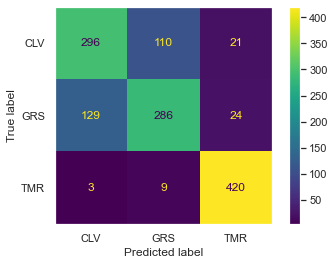

In [195]:
#Without feature selection
clf = Pipeline([
  #('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
  ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
predict_eval(clf, X_test, y_test, y_pred)

Accuracy: 0.7372881355932204


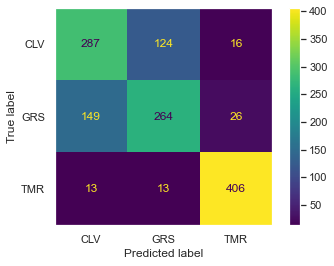

In [212]:
#Without feature selection
clf = Pipeline([
  #('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
  ('classification', LinearDiscriminantAnalysis())
])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
predict_eval(clf, X_test, y_test, y_pred)

In [ ]:
clf = RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
predict_eval(ridge, X_test, y_test, y_pred)

for idx in range(0, len(features)):
    #if selector.get_support()[idx]:
    print(features[idx], clf.coef_[:,idx])

Accuracy: 0.7827426810477658


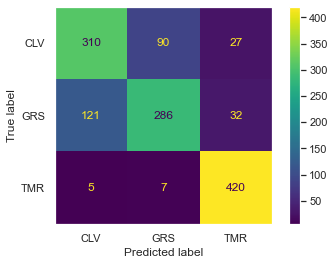


Classification report:
                precision    recall  f1-score   support

         CLV       0.71      0.73      0.72       427
         GRS       0.75      0.65      0.70       439
         TMR       0.88      0.97      0.92       432

    accuracy                           0.78      1298
   macro avg       0.78      0.78      0.78      1298
weighted avg       0.78      0.78      0.78      1298



In [196]:
#Testing feature selection
clf = Pipeline([
  ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
  ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
predict_eval(clf, X_test, y_test, y_pred)
printMetrics(y_test, y_pred)

In [255]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
  ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
])
algo = clf
folds = 3
print(algo)

scores = cross_validate(algo, X, y, scoring=error_measures, cv=folds)
#scores
acc = scores['test_accuracy']
fit_time = np.mean(scores['fit_time'])
score_time = np.mean(scores['score_time'])
print("acc: ", acc)
print("accCV: ", np.mean(acc))
#print("fit_time: ", fit_time)
#print("score_time: ", score_time)
print("time fit+score:", fit_time + score_time)
print("\n")

Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=RidgeClassifierCV(alphas=array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                                                             normalize=True))),
                ('classification',
                 RidgeClassifierCV(alphas=array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                                   normalize=True))])
acc:  [0.78003697 0.7826087  0.76965772]
accCV:  0.7774344628527361
time fit+score: 2.252575953801473




Accuracy: 0.7958397534668721


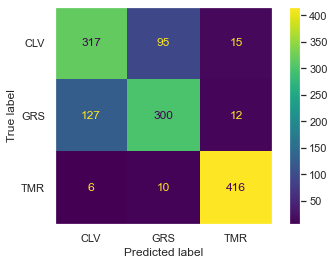


Classification report:
                precision    recall  f1-score   support

         CLV       0.70      0.74      0.72       427
         GRS       0.74      0.68      0.71       439
         TMR       0.94      0.96      0.95       432

    accuracy                           0.80      1298
   macro avg       0.79      0.80      0.79      1298
weighted avg       0.79      0.80      0.79      1298



In [197]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
  ('classification', LinearDiscriminantAnalysis())
])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
predict_eval(clf, X_test, y_test, y_pred)
printMetrics(y_test, y_pred)

In [ ]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
  ('classification', LinearDiscriminantAnalysis())
])
algo = clf
folds = 3
print(algo)

scores = cross_validate(algo, X, y, scoring=error_measures, cv=folds)
#scores
acc = scores['test_accuracy']
fit_time = np.mean(scores['fit_time'])
score_time = np.mean(scores['score_time'])
print("acc: ", acc)
print("accCV: ", np.mean(acc))
#print("fit_time: ", fit_time)
#print("score_time: ", score_time)
print("time fit+score:", fit_time + score_time)
print("\n")

In [216]:
selector = SelectFromModel(estimator=RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True)).fit(X_train, y_train)
#selector.estimator_.coef_
selector.threshold_
selector.get_support().sum()
#selector.get_support()

312

In [217]:
selector.estimator_.coef_

array([[ 12.31144564,  -5.60578064,  -9.98332534, ..., -11.12499045,
        -15.53104525, -16.16260089],
       [ -8.07238117,  11.69962293,  13.00672642, ...,   8.123713  ,
         12.66065365,  15.77988069],
       [ -4.23906447,  -6.09384229,  -3.02340108, ...,   3.00127745,
          2.8703916 ,   0.38272021]])

In [218]:
for idx in range(0, len(selector.get_support())):
    #if selector.get_support()[idx]:
    print(features[idx], selector.estimator_.coef_[:,idx])

col1 [12.31144564 -8.07238117 -4.23906447]
col2 [-5.60578064 11.69962293 -6.09384229]
col3 [-9.98332534 13.00672642 -3.02340108]
col4 [-2.69742595  2.95022275 -0.2527968 ]
col5 [ 8.10431386 -8.34018146  0.23586759]
col6 [ 14.04802176 -12.54033473  -1.50768702]
col7 [10.59347865 -7.09513985 -3.4983388 ]
col8 [-0.90371311  4.06636483 -3.16265173]
col9 [-14.01713736  13.15782483   0.85931252]
col10 [-21.02476343  13.51311078   7.51165265]
col11 [-17.96267572   4.24383837  13.71883735]
col12 [-7.41387961 -8.96774168 16.38162128]
col13 [  3.4142175  -17.96157836  14.54736086]
col14 [  7.91042006 -18.04174162  10.13132156]
col15 [  4.72546672 -11.38704039   6.66157368]
col16 [-1.5031915 -5.2503626  6.7535541]
col17 [-4.20966845 -5.90895773 10.11862618]
col18 [ -0.50636098 -13.37766356  13.88402454]
col19 [  6.62436765 -21.45686672  14.83249908]
col20 [ 11.03062765 -22.4620534   11.43142575]
col21 [  8.24196433 -12.74233989   4.50037556]
col22 [-1.17419516  4.19801956 -3.0238244 ]
col23 [-12.

col656 [ 1.10671321 -2.65947125  1.55275804]
col657 [-0.28487741  1.2874779  -1.00260048]
col658 [-0.17585809  0.87894592 -0.70308784]
col659 [-0.26922264 -0.9402602   1.20948284]
col660 [-0.57547644  1.23701071 -0.66153427]
col661 [ 1.00167414 -1.10056583  0.09889168]
col662 [ 1.33354925 -1.49869996  0.16515071]
col663 [-2.18793674  3.0556418  -0.86770506]
col664 [-0.55236648 -1.31205667  1.86442316]
col665 [ 0.6491601  -0.12952875 -0.51963135]
col666 [ 0.27649177  1.68959565 -1.96608742]
col667 [ 2.5760061  -2.63491027  0.05890417]
col668 [-1.4963578  -0.45601285  1.95237065]
col669 [-4.51022573  3.46126145  1.04896428]
col670 [ 2.88548649 -1.05062181 -1.83486467]
col671 [ 5.36375212 -4.1019936  -1.26175852]
col672 [-3.98514271  2.92841476  1.05672795]
col673 [-5.98772331  5.29450793  0.69321538]
col674 [ 4.15749254 -3.71910954 -0.43838301]
col675 [ 7.77061998 -7.50879043 -0.26182955]
col676 [-1.81502648  1.55188277  0.26314371]
col677 [-8.74877429  9.09059017 -0.34181588]
col678 [-2

In [191]:
#import numpy.ma as ma
#features_selected = ma.masked_where(selector.get_support(), features)
for idx in range(0, len(selector.get_support())):
    if selector.get_support()[idx]:
        print(features[idx])

col44
col45
col46
col47
col50
col51
col52
col53
col54
col55
col56
col57
col72
col73
col74
col76
col77
col78
col79
col80
col81
col82
col83
col84
col85
col86
col87
col88
col90
col91
col92
col93
col94
col95
col96
col97
col98
col99
col100
col101
col102
col104
col105
col106
col107
col108
col109
col110
col111
col112
col113
col115
col116
col119
col120
col121
col123
col124
col125
col126
col127
col128
col129
col130
col131
col132
col133
col134
col135
col136
col141
col142
col143
col144
col153
col154
col208
col219
col220
col221
col222
col227
col228
col229
col230
col231
col232
col233
col234
col235
col236
col237
col238
col239
col240
col241
col242
col243
col244
col245
col248
col249
col250
col253
col254
col255
col256
col257
col261
col262
col263
col264
col265
col271
col272
col273
col274
col275
col276
col279
col280
col281
col282
col283
col284
col285
col286
col287
col288
col289
col290
col291
col292
col293
col294
col295
col296
col297
col298
col299
col300
col301
col308
col309
col310
col311
col312
col313
co

In [190]:
for idx in range(0, len(selector.get_support())):
    if selector.get_support()[idx]:
        print(features[idx], selector.estimator_.coef_[:,idx])

col44 [-18.14038427  46.43425098 -28.29386671]
col45 [-18.1276669   61.23271929 -43.10505239]
col46 [-18.04197323  62.68677025 -44.64479701]
col47 [-17.68150463  47.30572142 -29.62421679]
col50 [ -3.01063855 -43.82477411  46.83541266]
col51 [  8.5688952  -57.67733198  49.10843678]
col52 [ 22.24672177 -52.61853357  30.3718118 ]
col53 [ 35.1834579  -30.17320138  -5.01025652]
col54 [ 42.62787185   2.30475857 -44.93263042]
col55 [ 39.16135857  32.45077901 -71.61213758]
col56 [ 24.14829422  46.68279585 -70.83109007]
col57 [  5.57311987  40.82955518 -46.40267505]
col72 [ 41.35430959   3.27261654 -44.62692613]
col73 [ 57.63519549  -8.45066193 -49.18453355]
col74 [ 47.85294709 -19.75587394 -28.09707315]
col76 [-47.72283434  -1.13379042  48.85662475]
col77 [-77.14840055  19.76114351  57.38725705]
col78 [-67.97111447  32.48564013  35.48547435]
col79 [-30.34450459  32.89612391  -2.55161933]
col80 [ 14.83970398  23.84496948 -38.68467346]
col81 [ 50.70099291   9.70723243 -60.40822533]
col82 [ 68.89

col896 [-32.48438254  20.98896819  11.49541435]
col897 [-37.44386903  23.77996337  13.66390567]
col898 [-30.90803732  17.93420323  12.97383409]
col906 [-34.53416941  28.59654038   5.93762903]
col907 [-35.80151741  28.6782828    7.1232346 ]
col908 [-29.29247243  23.02991943   6.262553  ]


In [198]:
#SFS is too expensive
clf = Pipeline([
  ('feature_selection', SequentialFeatureSelector(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True), n_features_to_select=500)),
  ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
predict_eval(clf, X_test, y_test, y_pred)
printMetrics(y_test, y_pred)


KeyboardInterrupt: 

# Findings so far

After comparing several algo with 3-fold cv:
+ RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True) works best, followed closely by LinearDiscriminantAnalysis()
+ FeatureSelection using SelectFromModel improves the Acc by 1.5%.

In [199]:
class IntervalSelector(BaseEstimator, TransformerMixin):
    # initializer 
    def __init__(self, start = 0, end = 10, return_timeseries = True):        
        self.start = start
        self.end = end
        self.return_timeseries = return_timeseries
            
            
    def fit(self, X, y = None):        
        return self    
    
    def transform(self, X, y = None):             
        if self.return_timeseries:
            return from_2d_array_to_nested(X.iloc[:,self.start:self.end])
        else:
            return X.iloc[:,self.start:self.end]

----------------------
Interval: 0 - 171
----------------------
Accuracy: 0.714175654853621


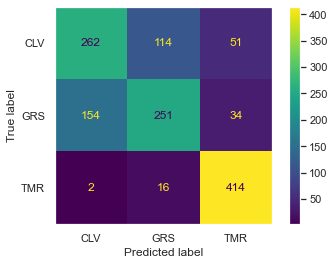

----------------------
Interval: 206 - 306
----------------------
Accuracy: 0.5539291217257319


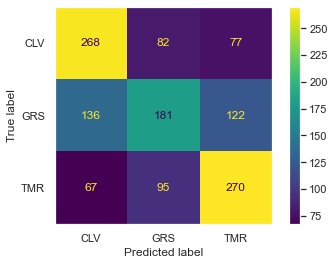

----------------------
Interval: 728 - 747
----------------------
Accuracy: 0.337442218798151


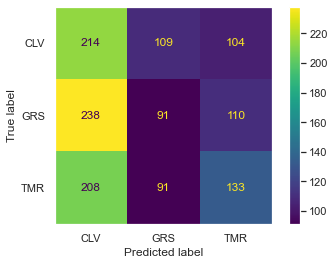

In [207]:
#Water region removal
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

intervals = [(0,171),(206,306),(728,747)]
results = {}

for itv_start, itv_end in intervals:
    print('----------------------')
    print(f'Interval: {itv_start} - {itv_end}')
    print('----------------------')
    chopper = IntervalSelector(itv_start,itv_end,return_timeseries = False)
    X_train_itv = chopper.transform(X_train)
    X_test_itv = chopper.transform(X_test)
    
    clf = Pipeline([
      #('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
      ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
    ])
    clf.fit(X_train_itv, y_train)
    y_pred = clf.predict(X_test_itv)
    predict_eval(clf, X_test_itv, y_test, y_pred)

Accuracy: 0.7627118644067796


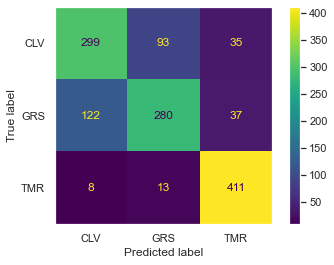

In [208]:
X_train_no_water = X_train.iloc[:, np.r_[0:171, 206:306, 728:747]]
X_test_no_water = X_test.iloc[:, np.r_[0:171, 206:306, 728:747]]

clf = Pipeline([
      #('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
      ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
    ])
clf.fit(X_train_no_water, y_train)
y_pred = clf.predict(X_test_no_water)
predict_eval(clf, X_test_no_water, y_test, y_pred)

Accuracy: 0.7727272727272727


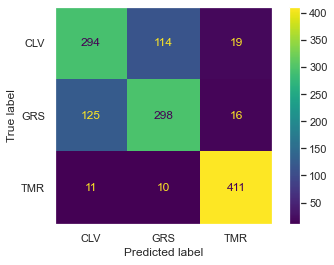

In [211]:
X_train_no_water = X_train.iloc[:, np.r_[0:171, 206:306, 728:747]]
X_test_no_water = X_test.iloc[:, np.r_[0:171, 206:306, 728:747]]

clf = Pipeline([
      #('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
      ('classification', LinearDiscriminantAnalysis())
    ])
clf.fit(X_train_no_water, y_train)
y_pred = clf.predict(X_test_no_water)
predict_eval(clf, X_test_no_water, y_test, y_pred)

In [214]:
#X_train_no_water = X_train.iloc[:, np.r_[0:171, 206:306, 728:747]]
#X_test_no_water = X_test.iloc[:, np.r_[0:171, 206:306, 728:747]]

clf = Pipeline([
      #('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
      ('classification', LinearDiscriminantAnalysis())
    ])

algo = clf
folds = 3
print(algo)

scores = cross_validate(algo, X.iloc[:, np.r_[0:171, 206:306, 728:747]], y, scoring=error_measures, cv=folds)
#scores
acc = scores['test_accuracy']
fit_time = np.mean(scores['fit_time'])
score_time = np.mean(scores['score_time'])
print("acc: ", acc)
print("accCV: ", np.mean(acc))
#print("fit_time: ", fit_time)
#print("score_time: ", score_time)
print("time fit+score:", fit_time + score_time)
print("\n")

Pipeline(steps=[('classification', LinearDiscriminantAnalysis())])
acc:  [0.77726433 0.76225717 0.75485661]
accCV:  0.7647927029524134
time fit+score: 0.16776506106058758




----------------------
Interval: 0 - 171
----------------------
Accuracy: 0.687211093990755


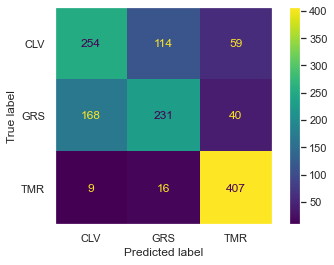

----------------------
Interval: 206 - 306
----------------------
Accuracy: 0.5184899845916795


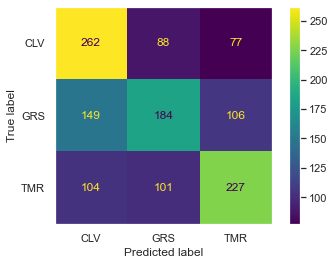

----------------------
Interval: 728 - 747
----------------------
Accuracy: 0.3443759630200308


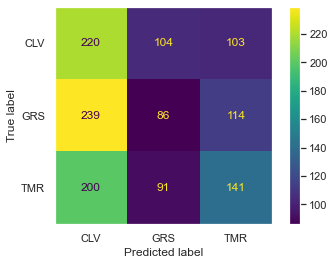

In [209]:
#Water region removal + feature selection
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

intervals = [(0,171),(206,306),(728,747)]
results = {}

for itv_start, itv_end in intervals:
    print('----------------------')
    print(f'Interval: {itv_start} - {itv_end}')
    print('----------------------')
    chopper = IntervalSelector(itv_start,itv_end,return_timeseries = False)
    X_train_itv = chopper.transform(X_train)
    X_test_itv = chopper.transform(X_test)
    
    clf = Pipeline([
      ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
      ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
    ])
    clf.fit(X_train_itv, y_train)
    y_pred = clf.predict(X_test_itv)
    predict_eval(clf, X_test_itv, y_test, y_pred)

Accuracy: 0.7526964560862865


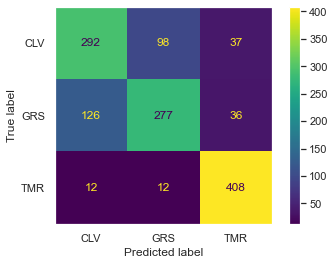

In [210]:
X_train_no_water = X_train.iloc[:, np.r_[0:171, 206:306, 728:747]]
X_test_no_water = X_test.iloc[:, np.r_[0:171, 206:306, 728:747]]

clf = Pipeline([
      ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
      ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
    ])
clf.fit(X_train_no_water, y_train)
y_pred = clf.predict(X_test_no_water)
predict_eval(clf, X_test_no_water, y_test, y_pred)

Accuracy: 0.7580893682588598


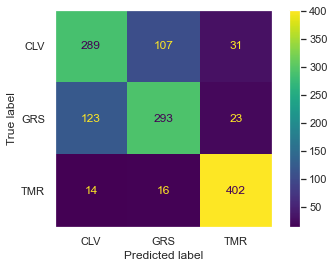

In [213]:
X_train_no_water = X_train.iloc[:, np.r_[0:171, 206:306, 728:747]]
X_test_no_water = X_test.iloc[:, np.r_[0:171, 206:306, 728:747]]

clf = Pipeline([
      ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
      ('classification', LinearDiscriminantAnalysis())
    ])
clf.fit(X_train_no_water, y_train)
y_pred = clf.predict(X_test_no_water)
predict_eval(clf, X_test_no_water, y_test, y_pred)

# Findings so far

After comparing several algo with 3-fold cv:
+ RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True) works best, followed closely by LinearDiscriminantAnalysis()
+ FeatureSelection using SelectFromModel improves the Acc by 1.5%.
+Best result so far: original data + feature selection (SelectFromModel()) + Ridge or LDA

In [252]:
# Try some noise removal before feature selection and learning
# Voting windows to do automatic water region removal
# Ideas to test: contiguous windows of fixed size, contiguous windows of random size, non-contiguous windows (essentially random feature subset selection of varying size)
def rankedWindows(X, y, runs, windowSize, useThreshold, classifier, threshold=0):

    results = {}
    numberOfWindows = len(X.columns) // windowSize
    
    xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.4, random_state = 0)
        
    for k in range(1,runs+1):

        print(f"Run {k}")

        validationScores = []
        testScores = []
        
        xTrainSplit, xValidate, yTrainSplit, yValidate = train_test_split(xTrain, yTrain, test_size=0.4)

        for n in range(0,numberOfWindows):

            #if(n%(numberOfWindows//10) == 0 and n != 0):
                #print(f"Progress: {round((n/numberOfWindows) * 100)}%")
                
            windowStart = n * windowSize
            windowEnd = windowStart + windowSize
            xTrainWindow = xTrainSplit.iloc[:,windowStart:windowEnd]
            xValidateWindow = xValidate.iloc[:,windowStart:windowEnd]
            
            if (classifier == "MiniRocket"):
                xTrainWindowSeries = from_2d_array_to_nested(xTrainWindow)
                xValidateWindowSeries = from_2d_array_to_nested(xValidateWindow)

                minirocket = MiniRocket()
                minirocket.fit(xTrainWindowSeries)
                xTrainTransform = minirocket.transform(xTrainWindowSeries)
                clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
                clf.fit(xTrainTransform, yTrainSplit)
                xValidateTransform = minirocket.transform(xValidateWindowSeries)
                y_pred = clf.predict(xValidateTransform)
                score = accuracy_score(y_pred, yValidate)
            
            
            elif (classifier == "RidgeClassifierCV"):
                clf = RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True)
                clf.fit(xTrainWindow, yTrainSplit)
                y_pred = clf.predict(xValidateWindow)
                score = accuracy_score(y_pred, yValidate)
                
            validationScores.append(score)
            
        if useThreshold:
            windowsAboveThreshold = [n for n in validationScores if validationScores[n] > threshold]

            print(windowsAboveThresholdAfterTest)

            for window in validationScores:
                if window in results:
                    results[window] += 1#
                else:
                    results[window] = 1
        else:
            for n in range(0,numberOfWindows):
                if n in results:
                    results[n] += validationScores[n]
                else:
                    results[n] = validationScores[n]
                    
    #print(validationScores)
    for n in range(0,numberOfWindows):
        results[n] = results[n] / runs
        
    sortedResults = sorted(results.items(), key=lambda x: x[1], reverse=True)
    
    updatedKeyResults = {}
    for key, value in results.items():
        newKeyStart = key*windowSize
        newKeyEnd = newKeyStart + windowSize
        updatedKeyResults[f"{newKeyStart}:{newKeyEnd}"] = value
        
    sortedResults = sorted(updatedKeyResults.items(), key=lambda x: x[1], reverse=True)
    return sortedResults

In [253]:
ridge_windows = rankedWindows(X, y, runs = 10, windowSize = 50 ,useThreshold = False, classifier = "RidgeClassifierCV")

Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
[0.6123234916559692, 0.5648267008985879, 0.6418485237483954, 0.43902439024390244, 0.47881899871630296, 0.44801026957637996, 0.3889602053915276, 0.392811296534018, 0.3684210526315789, 0.5468549422336328, 0.5802310654685494, 0.3722721437740693, 0.3465982028241335, 0.33504492939666236, 0.3632862644415918, 0.38125802310654683, 0.40051347881899874, 0.3735558408215661, 0.3607188703465982, 0.3363286264441592, 0.3607188703465982]


In [254]:
ridge_windows

[('100:150', 0.6322207958921694),
 ('0:50', 0.606803594351733),
 ('500:550', 0.5560975609756097),
 ('50:100', 0.5494223363286265),
 ('450:500', 0.5453145057766366),
 ('200:250', 0.47560975609756095),
 ('250:300', 0.42913992297817716),
 ('150:200', 0.42092426187419774),
 ('300:350', 0.39332477535301674),
 ('350:400', 0.3865211810012837),
 ('400:450', 0.3856225930680359),
 ('850:900', 0.3799743260590501),
 ('900:950', 0.3722721437740693),
 ('800:850', 0.3681643132220796),
 ('750:800', 0.3670089858793325),
 ('700:750', 0.35661103979460845),
 ('550:600', 0.3564826700898588),
 ('1000:1050', 0.35378690629011555),
 ('650:700', 0.34621309370988446),
 ('600:650', 0.34467265725288837),
 ('950:1000', 0.3430038510911425)]

In [246]:
minirocket_windows = rankedWindows(X, y, runs = 10, windowSize = 50 ,useThreshold = False, classifier = "MiniRocket")

Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10


In [247]:
minirocket_windows

[('0:50', 0.6175866495507061),
 ('100:150', 0.6129653401797175),
 ('50:100', 0.5593068035943517),
 ('450:500', 0.5539152759948652),
 ('500:550', 0.5075738125802312),
 ('200:250', 0.4623876765083441),
 ('400:450', 0.43555840821566105),
 ('250:300', 0.43401797175866497),
 ('150:200', 0.41861360718870355),
 ('350:400', 0.40487804878048783),
 ('300:350', 0.4033376123234917),
 ('850:900', 0.38973042362002563),
 ('700:750', 0.37406931964056483),
 ('900:950', 0.372400513478819),
 ('800:850', 0.37201540436457),
 ('950:1000', 0.36213093709884464),
 ('1000:1050', 0.35905006418485236),
 ('750:800', 0.3576379974326059),
 ('550:600', 0.34826700898587937),
 ('650:700', 0.3471116816431322),
 ('600:650', 0.33145057766367136)]

Accuracy: 0.773497688751926


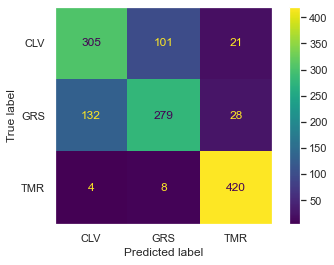

In [248]:
X_train_auto_windows = X_train.iloc[:, np.r_[0:550, 700:]]
X_test_auto_windows = X_test.iloc[:, np.r_[0:550, 700:]]

clf = Pipeline([
      #('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
      ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
    ])
clf.fit(X_train_auto_windows, y_train)
y_pred = clf.predict(X_test_auto_windows)
predict_eval(clf, X_test_auto_windows, y_test, y_pred)

Accuracy: 0.788135593220339


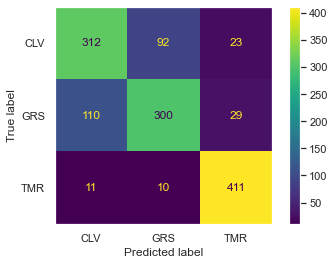

In [249]:
X_train_auto_windows = X_train.iloc[:, np.r_[0:550, 700:]]
X_test_auto_windows = X_test.iloc[:, np.r_[0:550, 700:]]

clf = Pipeline([
      ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
      ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
    ])
clf.fit(X_train_auto_windows, y_train)
y_pred = clf.predict(X_test_auto_windows)
predict_eval(clf, X_test_auto_windows, y_test, y_pred)

Accuracy: 0.7627118644067796


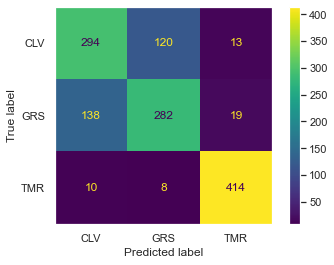

In [250]:
X_train_auto_windows = X_train.iloc[:, np.r_[0:550, 700:]]
X_test_auto_windows = X_test.iloc[:, np.r_[0:550, 700:]]

clf = Pipeline([
      #('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
      ('classification', LinearDiscriminantAnalysis())
    ])
clf.fit(X_train_auto_windows, y_train)
y_pred = clf.predict(X_test_auto_windows)
predict_eval(clf, X_test_auto_windows, y_test, y_pred)

Accuracy: 0.7919876733436055


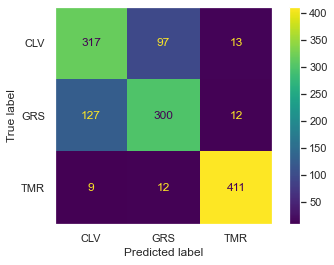

In [251]:
X_train_auto_windows = X_train.iloc[:, np.r_[0:550, 700:]]
X_test_auto_windows = X_test.iloc[:, np.r_[0:550, 700:]]

clf = Pipeline([
      ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
      ('classification', LinearDiscriminantAnalysis())
    ])
clf.fit(X_train_auto_windows, y_train)
y_pred = clf.predict(X_test_auto_windows)
predict_eval(clf, X_test_auto_windows, y_test, y_pred)